In [1]:
library(dplyr)
install.packages("leaps")  
library(leaps)
library(glmnet)
library(ggplot2)
library(car)
install.packages("corrplot")
library(corrplot)
library(reshape2)
install.packages("olsrr")
library(olsrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

corrplot 0.95 loaded

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers




# 1. Exploring and Processing Data

In [2]:
mpg_dataset <- read.table("auto-mpg.data", header = FALSE, sep = "", na.strings = "?")

colnames(mpg_dataset) <- c("mpg", "cylinders", "displacement", "horsepower", 
                    "weight", "acceleration", "model_year", "origin", "car_name")

mpg_dataset <- mpg_dataset %>% select(-car_name)
head(mpg_dataset)
# since the car_name is an identifier variable with no direct quantitative relevance to the target variable mpg, 
#so it is removed to simplify the model and focus on key explanatory variables

mpg cylinders displacement horsepower weight acceleration model_year origin
1 18  8         307          130        3504   12.0         70         1     
2 15  8         350          165        3693   11.5         70         1     
3 18  8         318          150        3436   11.0         70         1     
4 16  8         304          150        3433   12.0         70         1     
5 17  8         302          140        3449   10.5         70         1     
6 15  8         429          198        4341   10.0         70         1

In [3]:
str(mpg_dataset)
summary(mpg_dataset)# Descriptive Statistics
sum(is.na(mpg_dataset))# Checking for Missing Values


'data.frame':	398 obs. of  8 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  3504 3693 3436 3433 3449 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ model_year  : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...


      mpg          cylinders      displacement     horsepower        weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   Min.   : 46.0   Min.   :1613  
 1st Qu.:17.50   1st Qu.:4.000   1st Qu.:104.2   1st Qu.: 75.0   1st Qu.:2224  
 Median :23.00   Median :4.000   Median :148.5   Median : 93.5   Median :2804  
 Mean   :23.51   Mean   :5.455   Mean   :193.4   Mean   :104.5   Mean   :2970  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:262.0   3rd Qu.:126.0   3rd Qu.:3608  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   Max.   :230.0   Max.   :5140  
                                                 NA's   :6                     
  acceleration     model_year        origin     
 Min.   : 8.00   Min.   :70.00   Min.   :1.000  
 1st Qu.:13.82   1st Qu.:73.00   1st Qu.:1.000  
 Median :15.50   Median :76.00   Median :1.000  
 Mean   :15.57   Mean   :76.01   Mean   :1.573  
 3rd Qu.:17.18   3rd Qu.:79.00   3rd Qu.:2.000  
 Max.   :24.80   Max.   :82.00   Max.   :3.000  
                 

[1] 6

In [4]:
mpg_dataset$horsepower[is.na(mpg_dataset$horsepower)] <- median(mpg_dataset$horsepower, na.rm = TRUE)
# We Use the Median to Impute Missing Values

sum(is.na(mpg_dataset))# Checking for Missing Values again

[1] 0

# 2. Variable Selection

In [5]:
full_model <- lm(mpg ~ ., data = mpg_dataset) 
summary(full_model)


Call:
lm(formula = mpg ~ ., data = mpg_dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5958 -2.1547 -0.1183  1.9118 12.9942 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.791e+01  4.604e+00  -3.890 0.000118 ***
cylinders    -4.205e-01  3.220e-01  -1.306 0.192393    
displacement  1.905e-02  7.515e-03   2.535 0.011620 *  
horsepower   -1.239e-02  1.347e-02  -0.919 0.358415    
weight       -6.697e-03  6.439e-04 -10.401  < 2e-16 ***
acceleration  9.811e-02  9.705e-02   1.011 0.312686    
model_year    7.558e-01  5.051e-02  14.964  < 2e-16 ***
origin        1.424e+00  2.759e-01   5.163 3.88e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.337 on 390 degrees of freedom
Multiple R-squared:  0.8209,	Adjusted R-squared:  0.8177 
F-statistic: 255.4 on 7 and 390 DF,  p-value: < 2.2e-16


                    mpg  cylinders displacement horsepower     weight
mpg           1.0000000 -0.7753963   -0.8042028 -0.7734532 -0.8317409
cylinders    -0.7753963  1.0000000    0.9507214  0.8412845  0.8960168
displacement -0.8042028  0.9507214    1.0000000  0.8957782  0.9328241
horsepower   -0.7734532  0.8412845    0.8957782  1.0000000  0.8624424
weight       -0.8317409  0.8960168    0.9328241  0.8624424  1.0000000
acceleration  0.4202889 -0.5054195   -0.5436841 -0.6865897 -0.4174573
model_year    0.5792671 -0.3487458   -0.3701642 -0.4137328 -0.3065643
origin        0.5634504 -0.5625433   -0.6094094 -0.4520958 -0.5810239
             acceleration model_year     origin
mpg             0.4202889  0.5792671  0.5634504
cylinders      -0.5054195 -0.3487458 -0.5625433
displacement   -0.5436841 -0.3701642 -0.6094094
horsepower     -0.6865897 -0.4137328 -0.4520958
weight         -0.4174573 -0.3065643 -0.5810239
acceleration    1.0000000  0.2881370  0.2058730
model_year      0.2881370  1.00000

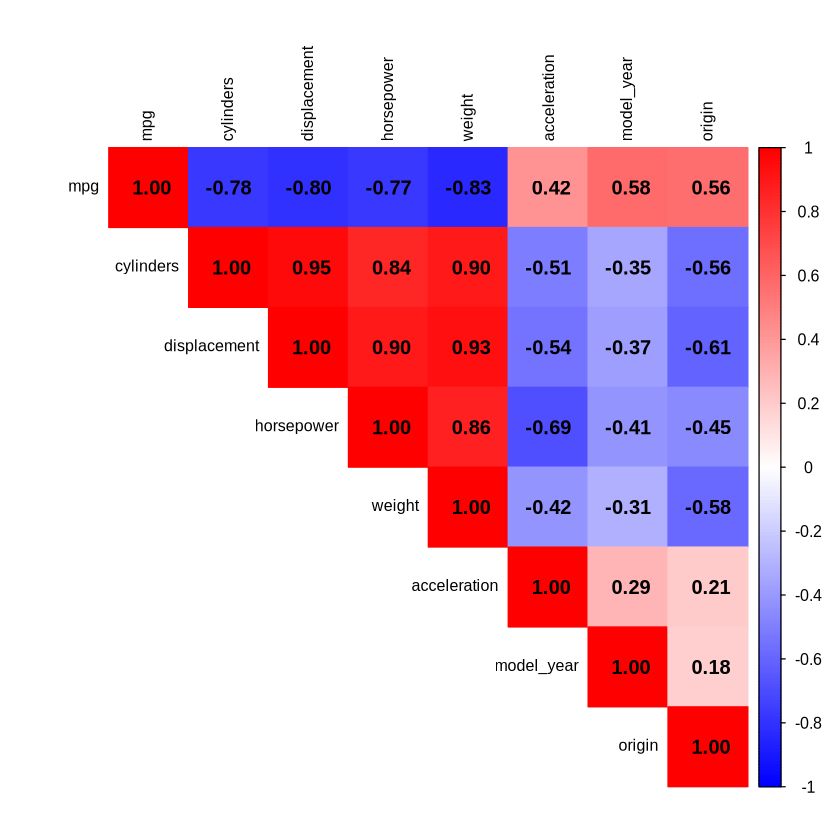

In [6]:
# the correlation matrix
cor_matrix <- cor(mpg_dataset, use = "complete.obs")

print(cor_matrix)

# the corrplot
corrplot(cor_matrix, method = "color", type = "upper",
         col = colorRampPalette(c("blue", "white", "red"))(200),
         tl.cex = 0.8, tl.col = "black", addCoef.col = "black")


In [7]:
vif_results <- vif(full_model)
print(vif_results)

   cylinders displacement   horsepower       weight acceleration   model_year 
   10.696808    21.893048     9.451325    10.601800     2.553707     1.243600 
      origin 
    1.745476 


**In the full model, we observed that some variables have high VIF values (e.g., displacement and weight with VIF values of 21.89 and 10.60, respectively), indicating potential multicollinearity issues in the data. Additionally, some variables in the full model (such as horsepower and acceleration) exhibit low significance, suggesting they may have limited explanatory power for the target variable, mpg. Therefore, to effectively identify important variables while addressing multicollinearity, we proceed with Lasso for variable selection and model regularization.**

In [8]:
X <- model.matrix(mpg ~ ., data = mpg_dataset)[, -1] 
# Remove the intercept column, which is our response variable
y <- mpg_dataset$mpg

In [9]:
set.seed(456)
lasso_model <- cv.glmnet(X, y, alpha = 1) 
# Use cross-validation to find the optimal regularization parameter lambda
best_lambda <- lasso_model$lambda.min 
best_lambda


[1] 0.0746503

In [10]:
lasso_coef <- coef(lasso_model, s = best_lambda)
# extract the coefficients of the optimal model
selected_vars <- rownames(lasso_coef)[lasso_coef[, 1] != 0]  
selected_vars <- selected_vars[selected_vars != "(Intercept)"]  
cat("Variables Selected by Lasso:\n", paste(selected_vars, collapse = ", "), "\n")

Variables Selected by Lasso:
 horsepower, weight, acceleration, model_year, origin 


In [11]:
lasso_data <- mpg_dataset[, c("mpg", selected_vars)]
best_subset_model <- regsubsets(mpg ~ ., data = lasso_data, nvmax = length(selected_vars))  
# nvmax is the maximum number of variables we use here
best_subset_summary <- summary(best_subset_model)
cat("The results of best subset selection:\n")
print(best_subset_summary$outmat)

The results of best subset selection:
         horsepower weight acceleration model_year origin
1  ( 1 ) " "        "*"    " "          " "        " "   
2  ( 1 ) " "        "*"    " "          "*"        " "   
3  ( 1 ) " "        "*"    " "          "*"        "*"   
4  ( 1 ) " "        "*"    "*"          "*"        "*"   
5  ( 1 ) "*"        "*"    "*"          "*"        "*"   


**Find the Model with the Maximum Adjusted R² Using Best Subset Selection**

In [12]:
best_model_size <- which.max(best_subset_summary$adjr2) 
cat("Number of Variables Included in the Best Model:", best_model_size, "\n")

Number of Variables Included in the Best Model: 4 


In [13]:
best_vars <- names(which(best_subset_summary$which[best_model_size, ] == TRUE))[-1]  #without the intercept
cat("Variables in the Best Model:\n", paste(best_vars, collapse = ", "), "\n")

Variables in the Best Model:
 weight, acceleration, model_year, origin 


# 3. Explore the relationship between important variables and MPG

`geom_smooth()` using formula = 'y ~ x'


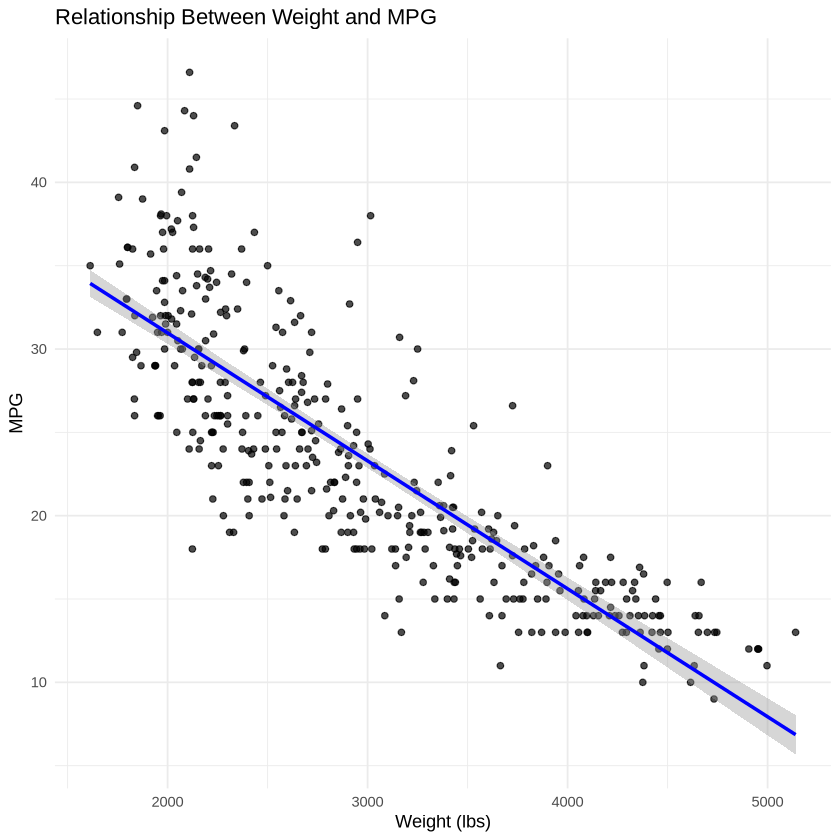

In [14]:
#weight vs mpg
ggplot(mpg_dataset, aes(x = weight, y = mpg)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", color = "blue") +  
  labs(title = "Relationship Between Weight and MPG",
       x = "Weight (lbs)", y = "MPG") +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'


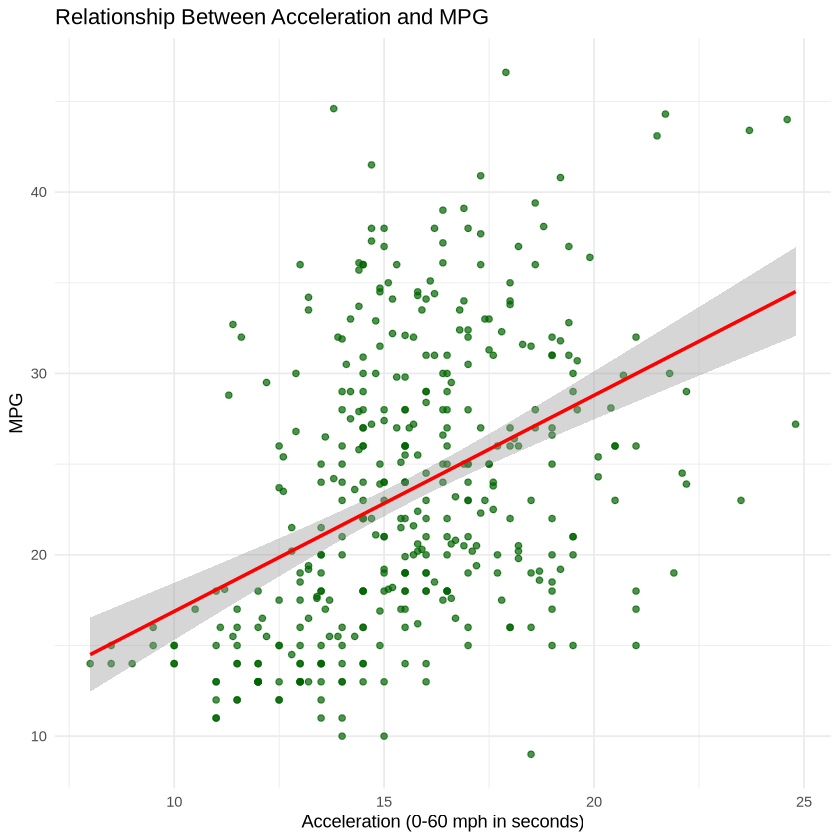

In [15]:
#acceleration vs mpg

ggplot(mpg_dataset, aes(x = acceleration, y = mpg)) +
  geom_point(alpha = 0.7, color = "darkgreen") +
  geom_smooth(method = "lm", color = "red") +  
  labs(title = "Relationship Between Acceleration and MPG",
       x = "Acceleration (0-60 mph in seconds)", y = "MPG") +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


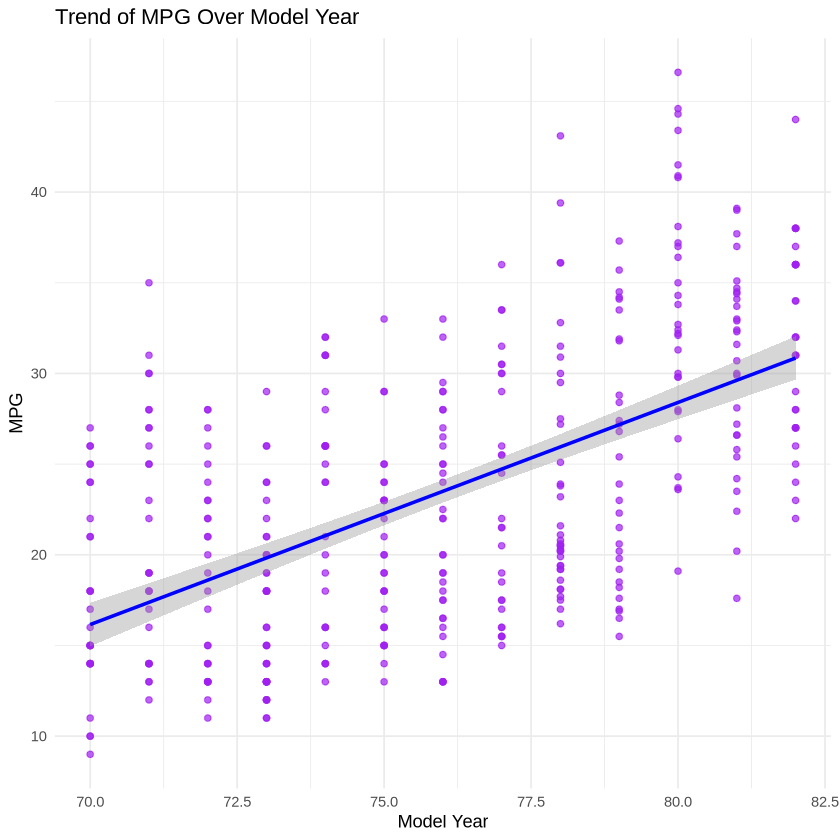

In [16]:
#model_year vs mpg

ggplot(mpg_dataset, aes(x = model_year, y = mpg)) +
  geom_point(alpha = 0.7, color = "purple") +
  geom_smooth(method = "lm", color = "blue") +  
  labs(title = "Trend of MPG Over Model Year",
       x = "Model Year", y = "MPG") +
  theme_minimal()

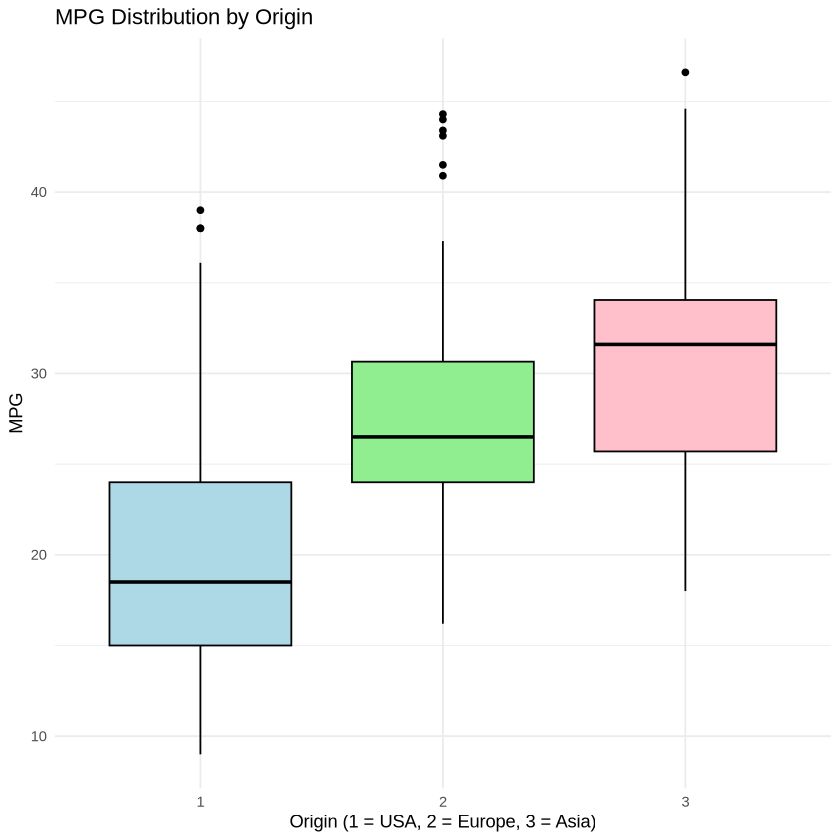

In [17]:
#origin vs mpg 

ggplot(mpg_dataset, aes(x = factor(origin), y = mpg, fill = factor(origin))) +
  geom_boxplot(color = "black") +
  scale_fill_manual(values = c("lightblue", "lightgreen", "pink")) +  
  labs(title = "MPG Distribution by Origin",
       x = "Origin (1 = USA, 2 = Europe, 3 = Asia)", y = "MPG") +
  theme_minimal() +
  theme(legend.position = "none")  


# 4. model comparison and selection

**To further quantify the impact of these variables, we conducted a multiple linear regression analysis on them. Since the four variables (weight, acceleration, model_year, origin) were selected using the Best Subset Selection method, they will all be retained in the subsequent model building process. Instead of removing any variables, we will focus on evaluating their contributions and interactions within the models**

In [18]:
full_additive_model <- lm(mpg~weight + acceleration + model_year + origin , data = mpg_dataset)
summary(full_additive_model)
vif(full_additive_model) 


Call:
lm(formula = mpg ~ weight + acceleration + model_year + origin, 
    data = mpg_dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8230 -2.1282 -0.0342  1.7693 13.1528 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.858e+01  4.012e+00  -4.630 4.97e-06 ***
weight       -5.930e-03  2.672e-04 -22.192  < 2e-16 ***
acceleration  7.195e-02  6.842e-02   1.052    0.294    
model_year    7.464e-01  4.865e-02  15.341  < 2e-16 ***
origin        1.180e+00  2.581e-01   4.573 6.46e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.353 on 393 degrees of freedom
Multiple R-squared:  0.8179,	Adjusted R-squared:  0.816 
F-statistic: 441.2 on 4 and 393 DF,  p-value: < 2.2e-16


weight acceleration   model_year       origin 
    1.808820     1.257330     1.143102     1.513603

In [19]:
full_interaction_model <- lm(mpg ~ weight * acceleration * model_year * origin, data = mpg_dataset)
summary(full_interaction_model)


Call:
lm(formula = mpg ~ weight * acceleration * model_year * origin, 
    data = mpg_dataset)

Residuals:
   Min     1Q Median     3Q    Max 
-8.986 -1.905 -0.045  1.441 11.723 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                           -2.056e+02  2.407e+02  -0.854    0.394
weight                                 4.529e-02  9.006e-02   0.503    0.615
acceleration                          -1.156e-01  1.480e+01  -0.008    0.994
model_year                             3.019e+00  3.150e+00   0.958    0.338
origin                                 9.857e+01  1.839e+02   0.536    0.592
weight:acceleration                    1.496e-03  5.558e-03   0.269    0.788
weight:model_year                     -5.852e-04  1.172e-03  -0.499    0.618
acceleration:model_year                1.345e-02  1.942e-01   0.069    0.945
weight:origin                         -1.769e-02  7.701e-02  -0.230    0.818
acceleration:origin                

In [37]:
interaction_model <- lm(mpg ~ weight * origin + acceleration * origin + model_year, data = mpg_dataset)
summary(interaction_model)


Call:
lm(formula = mpg ~ weight * origin + acceleration * origin + 
    model_year, data = mpg_dataset)

Residuals:
   Min     1Q Median     3Q    Max 
-9.322 -1.984 -0.088  1.669 11.260 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.256e+01  4.901e+00  -2.562  0.01078 *  
weight              -4.617e-03  6.462e-04  -7.145 4.43e-12 ***
origin              -4.424e+00  2.250e+00  -1.967  0.04993 *  
acceleration        -7.230e-01  1.574e-01  -4.594 5.88e-06 ***
model_year           7.924e-01  4.609e-02  17.191  < 2e-16 ***
weight:origin       -1.294e-03  4.968e-04  -2.605  0.00954 ** 
origin:acceleration  5.336e-01  9.545e-02   5.590 4.26e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.146 on 391 degrees of freedom
Multiple R-squared:  0.8404,	Adjusted R-squared:  0.838 
F-statistic: 343.2 on 6 and 391 DF,  p-value: < 2.2e-16


In [31]:
cp_model_1 <- ols_mallows_cp(full_model, interaction_model)
print(paste("interaction_model:", cp_model_1)) #new!!!!

[1] "interaction_model: 56.7114647071489"


**Model Specification Rationale for the interaction model (why we fit the model like this?)**\（改下）
The model was designed to capture the main effects of weight, acceleration, model_year, and origin, while including key interactions (weight:model_year and acceleration:model_year) to reflect how technological advancements influence the impact of weight and acceleration on fuel efficiency. Origin was included as a main effect to account for regional differences but excluded from interactions, as it represents a fixed characteristic rather than a dynamic factor.

**Rationale for Selecting the interaction_model**\ （改下）
The interaction model `(mpg ~ weight * model_year + acceleration * model_year + origin)` was selected because it strikes a balance between capturing meaningful relationships and maintaining interpretability. Compared to the additive model, it incorporates key interactions (`weight:model_year` and `model_year:acceleration`), which reflect how technological advancements (represented by model_year) influence the effects of weight and acceleration on fuel efficiency. This allows the model to better capture the dynamic relationships between variables, as suggested by both theory and data.

While the full interaction model offers slightly better performance metrics (higher Adjusted R^2 and lower Residual Standard Error), it includes a large number of higher-order interaction terms that are difficult to interpret and often lack clear theoretical justification. In contrast, the final model focuses on interactions that are both practically meaningful and theoretically grounded, avoiding unnecessary complexity and potential overfitting. By doing so, it achieves a good balance of model performance and interpretability, making it the most appropriate choice for addressing the research question.

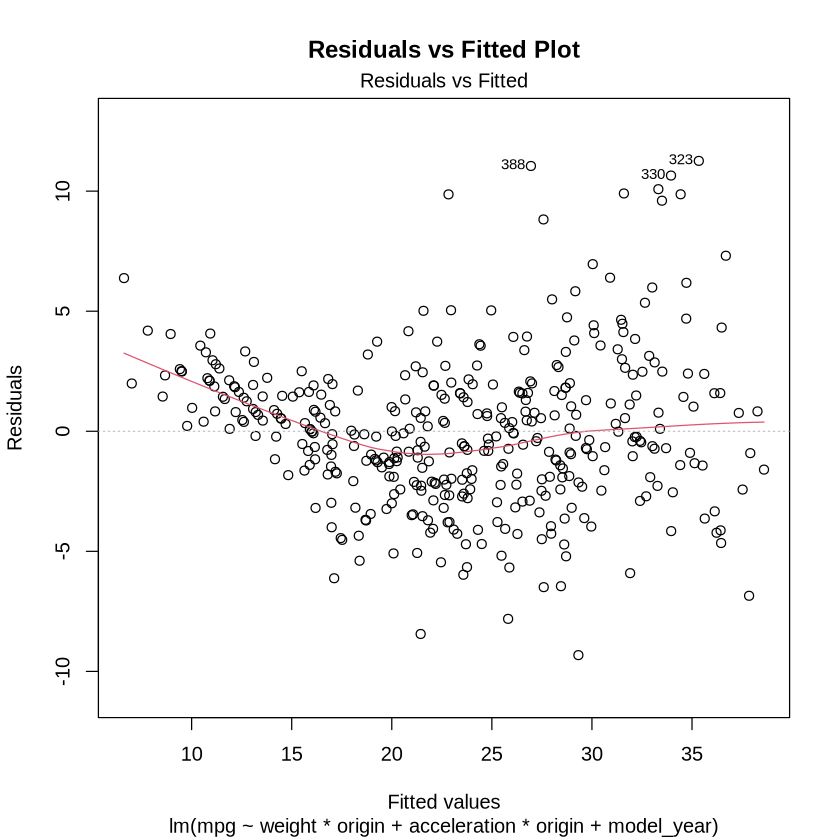

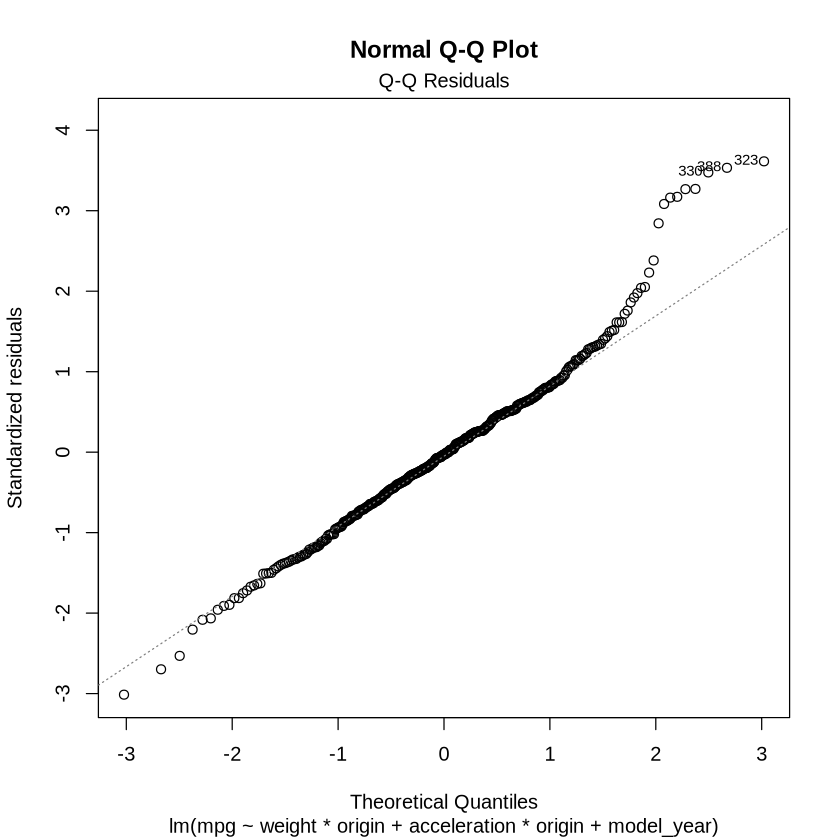

In [30]:
# Residuals vs Fitted Plot(new)
plot(interaction_model, which = 1, main = "Residuals vs Fitted Plot")
# Normal Q-Q Plot(new)
plot(interaction_model, which = 2, main = "Normal Q-Q Plot")


### interaction_model(改下）

The **Residuals vs. Fitted Plot** for the original model reveals some critical issues. There is clear evidence of heteroscedasticity, where the spread of residuals increases as the fitted values increase. This indicates a violation of the assumption of constant variance, which is essential for linear regression models. Additionally, a slight nonlinear pattern is observed, as the residuals do not appear to be evenly centered around zero across the range of fitted values. This suggests that the model does not fully capture the underlying relationship between the predictors and the response variable. To address these issues, introducing a polynomial term such as `poly(weight, 2)` can help account for the nonlinearity in the data.

Why `poly(weight, 2)` instead of `weight^2`?
If the raw terms are included such as weight and weight^2, they could be highly correlated, which would lead to multicollinearity issues. Multicollinearity inflates the standard errors of the coefficients, making it harder to assess their significance. However, orthogonal polynomials address this by creating uncorrelated components, ensuring that each term adds unique information to the model.


The **Normal Q-Q Plot** for the original model highlights further issues. There are significant deviations from the diagonal line, particularly in the tails, which indicate that the residuals are not normally distributed. This is a violation of the normality assumption, which is crucial for valid inference in linear regression. One way to resolve this issue is by transforming the response variable, such as applying a logarithmic transformation, to stabilize the variance and normalize the residuals.

# 5.Model improvement

In [38]:
improved_model <- lm(mpg ~ poly(weight, 2) * origin + acceleration * origin + model_year, data = mpg_dataset)
summary(improved_model)#new


Call:
lm(formula = mpg ~ poly(weight, 2) * origin + acceleration * 
    origin + model_year, data = mpg_dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9443 -1.6591 -0.0738  1.6036 11.9803 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -30.42005    3.75716  -8.097 7.34e-15 ***
poly(weight, 2)1        -104.23830   23.55448  -4.425 1.25e-05 ***
poly(weight, 2)2          45.74459   12.48698   3.663 0.000283 ***
origin                    -7.64892    1.68193  -4.548 7.26e-06 ***
acceleration              -0.61799    0.14646  -4.220 3.05e-05 ***
model_year                 0.83072    0.04275  19.433  < 2e-16 ***
poly(weight, 2)1:origin   -5.67928   22.37521  -0.254 0.799769    
poly(weight, 2)2:origin  -13.67615   11.36095  -1.204 0.229404    
origin:acceleration        0.49852    0.08989   5.546 5.41e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.9 on 389 deg

In [42]:
cp_model_2 <- ols_mallows_cp(full_model, improved_model)
print(paste("improved_model:", cp_model_2))#new

[1] "improved_model: 134.49392887178"


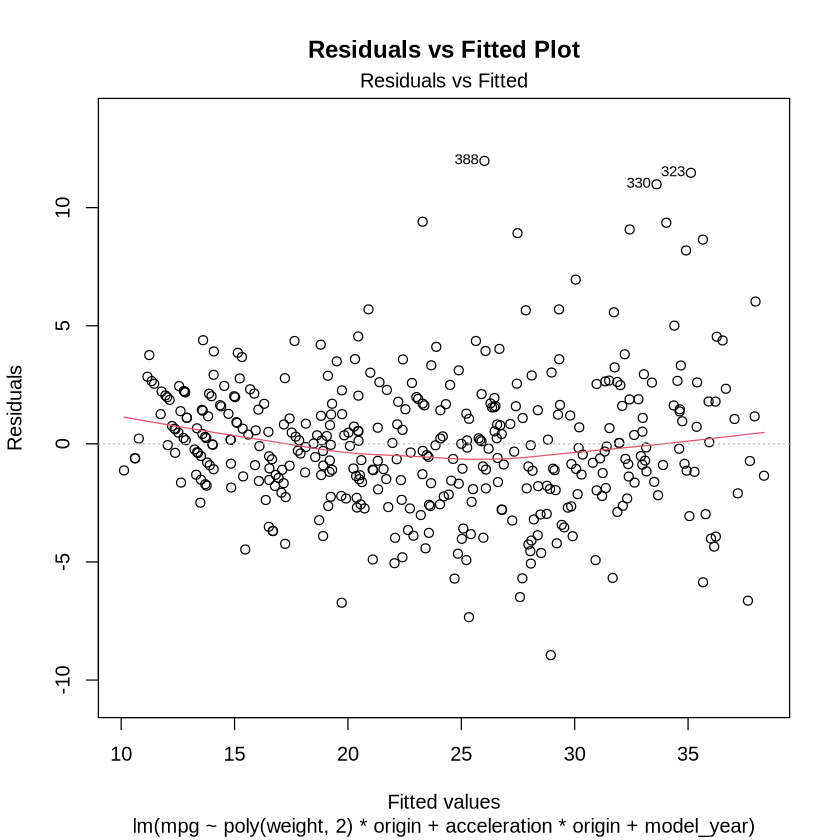

In [33]:
plot(improved_model, which = 1, main = "Residuals vs Fitted Plot")#new

For residual plot,after introducing a second-degree polynomial term for weight, the residual plot shows improved randomness, indicating that the model better captures the nonlinear relationship between weight and fuel efficiency.

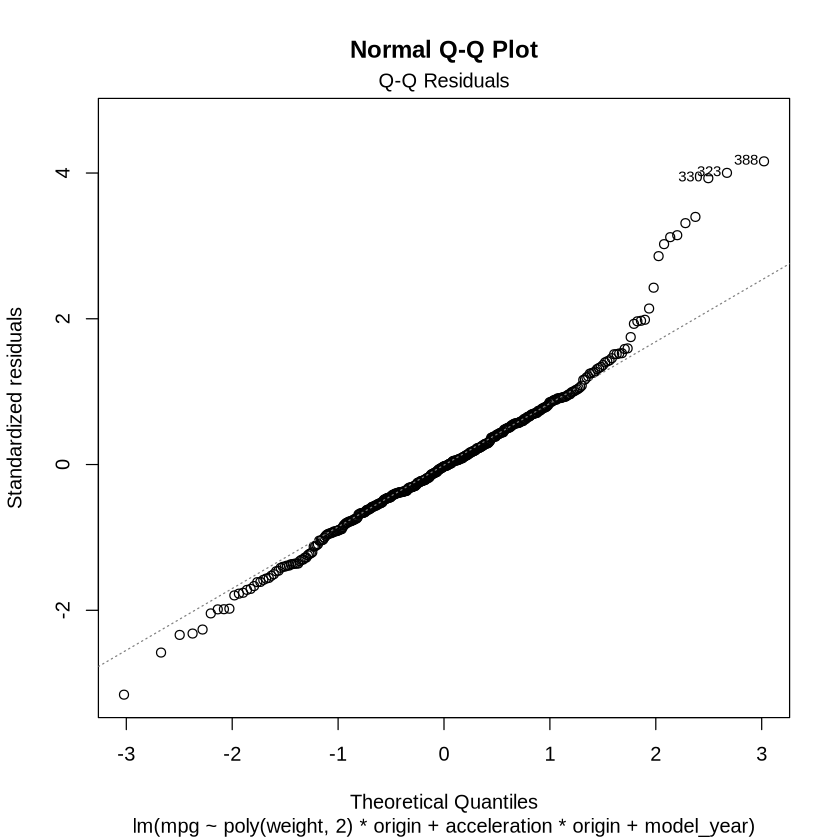

In [34]:
plot(improved_model, which = 2, main = "Normal Q-Q Plot")#new

The Q-Q plot demonstrates that residuals align more closely with the normal distribution, with only a few outliers at the tails. These outliers are likely due to specific data characteristics and do not substantially affect the model's conclusions.

### The improved model
The improved model, defined as `lm(mpg ~ poly(weight, 2) * model_year + acceleration * model_year + origin, data = mpg_dataset)`, introduces a polynomial term for the weight variable. This modification aimed to address the nonlinearity observed in the original model.

The **Residuals vs. Fitted Plot** for the second model shows noticeable improvements. By introducing `poly(weight, 2)`, the model captures some of the nonlinear patterns in the data, resulting in residuals that are better centered around zero. Additionally, heteroscedasticity is somewhat reduced, though not completely eliminated, as there is still a slight increase in the spread of residuals at higher fitted values. While this is an improvement, the residuals are still not perfectly random or evenly distributed, indicating that further adjustments are necessary.

The **Normal Q-Q Plot** for the second model still exhibits deviations from the diagonal line, particularly in the tails. This indicates that the residuals are not fully normal, suggesting that additional transformations are needed to address the issue. 

To improve the model further, we decided to log-transform the response variable `mpg`. Applying a logarithmic transformation helps stabilize variance, especially when residual variance increases with the mean response. Additionally, log transformations are commonly used for skewed data to make the distribution more symmetric and improve adherence to the assumptions of linear regression.

In [44]:
improved_model2 <- lm(log(mpg) ~ poly(weight, 2) * origin + acceleration * origin + model_year, data = mpg_dataset)
summary(improved_model2)


Call:
lm(formula = log(mpg) ~ poly(weight, 2) * origin + acceleration * 
    origin + model_year, data = mpg_dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39593 -0.06364  0.00600  0.06636  0.40863 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.868624   0.146512   5.929 6.74e-09 ***
poly(weight, 2)1        -5.391537   0.918515  -5.870 9.35e-09 ***
poly(weight, 2)2         1.251996   0.486934   2.571 0.010506 *  
origin                  -0.223268   0.065588  -3.404 0.000733 ***
acceleration            -0.017285   0.005711  -3.027 0.002638 ** 
model_year               0.032583   0.001667  19.546  < 2e-16 ***
poly(weight, 2)1:origin  0.201685   0.872529   0.231 0.817320    
poly(weight, 2)2:origin -0.442760   0.443024  -0.999 0.318220    
origin:acceleration      0.015439   0.003505   4.405 1.37e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1131 on

In [45]:
cp_model_3 <- ols_mallows_cp(full_model, improved_model2)
print(paste("improved_model2:", cp_model_3))#new

[1] "improved_model2: 339274.720174357"


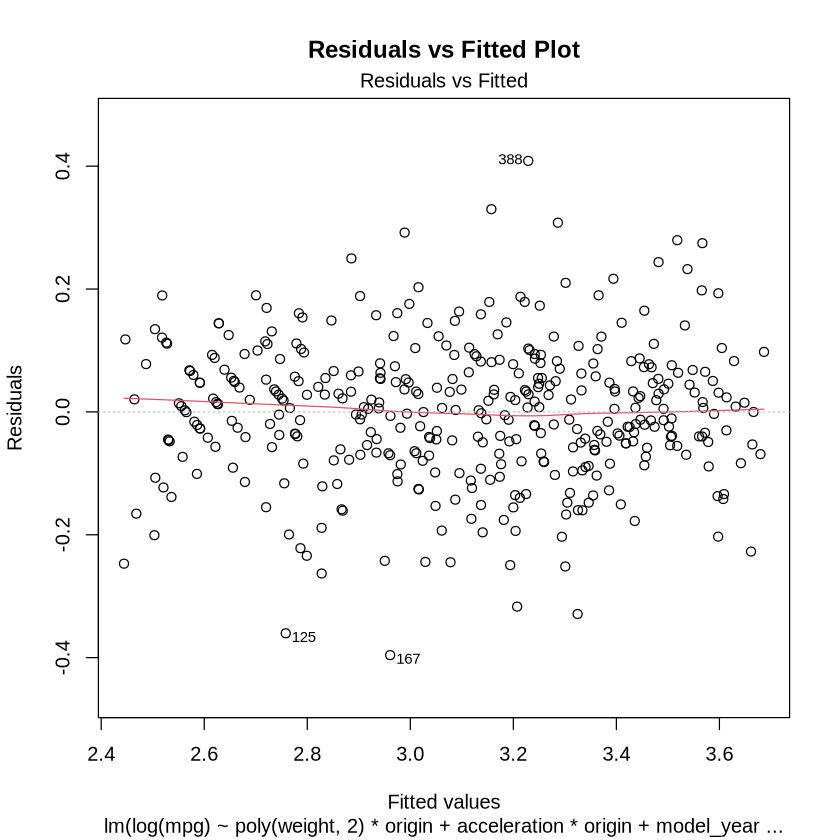

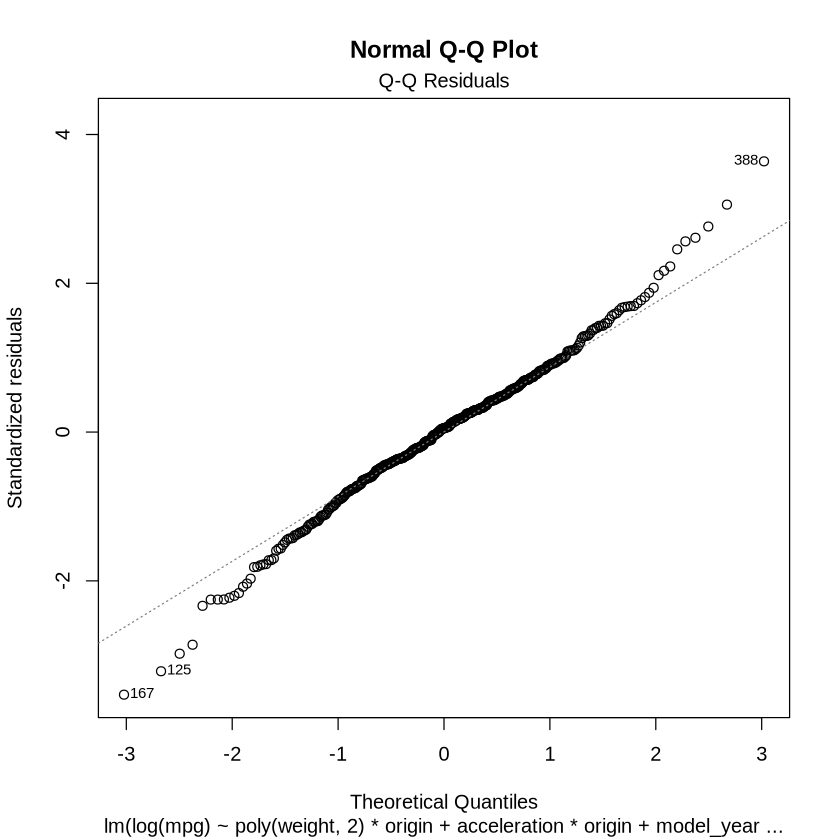

In [40]:
# Residuals vs Fitted Plot#new
plot(improved_model2 , which = 1, main = "Residuals vs Fitted Plot")
# Normal Q-Q Plot
plot(improved_model2 , which = 2, main = "Normal Q-Q Plot")


### improved_model2

The Residuals vs. Fitted Plot for the final model(improved_model2) demonstrates significant improvement. The log transformation successfully addressed heteroscedasticity, as the residual spread is now more uniform across the range of fitted values. The residuals are also well-centered around zero with no apparent patterns, fulfilling the assumption of randomness and constant variance.

The Normal Q-Q Plot for the final model shows remarkable improvement as well. The residuals align closely with the diagonal line, indicating that the log transformation resolved the issue of non-normality. Extreme deviations in the tails are greatly reduced, demonstrating that the residuals now adhere more closely to a normal distribution.

From a statistical perspective, the log transformation stabilizes variance and normalizes the data, resulting in better diagnostic plots and more reliable inference. Additionally, the final model achieved the highest adjusted R-squared value among all three models, indicating that it provides the best overall fit and explanatory power.

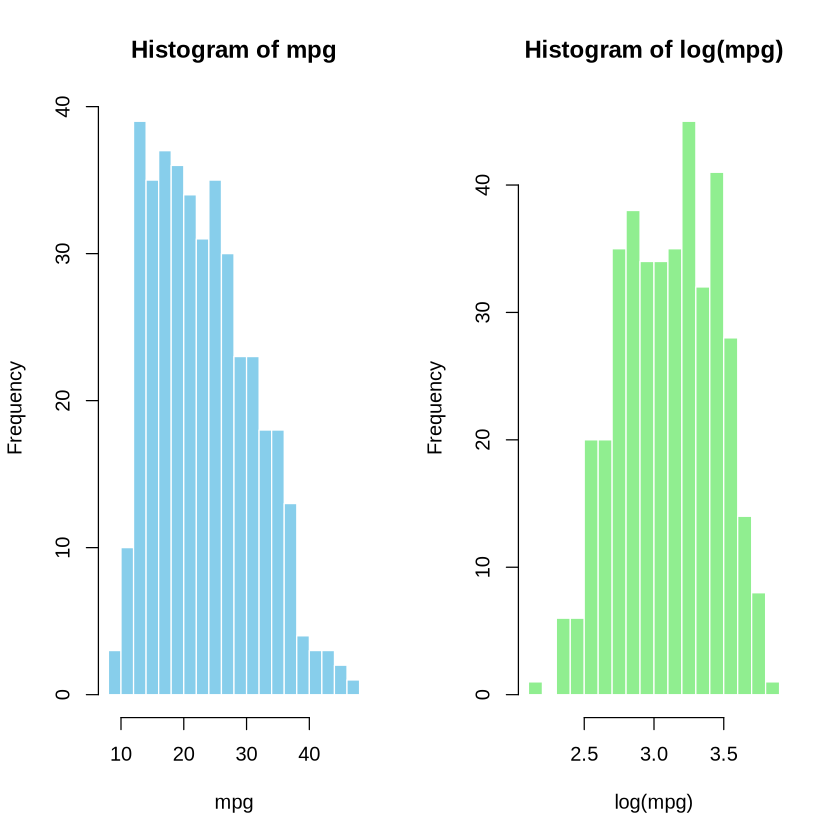

In [27]:
par(mfrow = c(1, 2)) 

# mpg distribution
hist(mpg_dataset$mpg, 
     main = "Histogram of mpg", 
     xlab = "mpg", 
     col = "skyblue", 
     border = "white", 
     breaks = 20)

# log(mpg) ditribution
hist(log(mpg_dataset$mpg), 
     main = "Histogram of log(mpg)", 
     xlab = "log(mpg)", 
     col = "lightgreen", 
     border = "white", 
     breaks = 20)


# Analysis of the Histogram Comparison: `mpg` vs. `log(mpg)`

The histograms compare the original `mpg` (left) and its log-transformed version `log(mpg)` (right). 

### Histogram of `mpg`
- The `mpg` histogram is **right-skewed**, with more observations at lower values and a long tail at higher values.
- This skewness can cause violations of regression assumptions, such as **non-normality of residuals** and **heteroscedasticity**, where the variance of residuals increases with the predicted values.

### Histogram of `log(mpg)`
- The log transformation produces a **symmetric, bell-shaped distribution**, reducing skewness and stabilizing variance.
- This transformation improves the normality of residuals, helps achieve constant variance, and reduces the impact of outliers, making the data more suitable for linear regression.
- 
The log transformation of `mpg` addresses the issues of skewness and heteroscedasticity, ensuring better adherence to regression assumptions and improving model robustness.


In [41]:
#recall the final model we use (improved_model2)
improved_model2 <- lm(log(mpg) ~ poly(weight, 2) * origin + acceleration * origin + model_year, data = mpg_dataset)
summary(improved_model2)


Call:
lm(formula = log(mpg) ~ poly(weight, 2) * origin + acceleration * 
    origin + model_year, data = mpg_dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39593 -0.06364  0.00600  0.06636  0.40863 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.868624   0.146512   5.929 6.74e-09 ***
poly(weight, 2)1        -5.391537   0.918515  -5.870 9.35e-09 ***
poly(weight, 2)2         1.251996   0.486934   2.571 0.010506 *  
origin                  -0.223268   0.065588  -3.404 0.000733 ***
acceleration            -0.017285   0.005711  -3.027 0.002638 ** 
model_year               0.032583   0.001667  19.546  < 2e-16 ***
poly(weight, 2)1:origin  0.201685   0.872529   0.231 0.817320    
poly(weight, 2)2:origin -0.442760   0.443024  -0.999 0.318220    
origin:acceleration      0.015439   0.003505   4.405 1.37e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1131 on

# Interpretation of the Final Model Coefficients

The final model provides estimates of how each variable (and their interactions) affects the log-transformed miles per gallon (`log(mpg)`) while holding other variables constant. Here's a breakdown of each coefficient:

---

### **Intercept**
- **Estimate**: `4.0253927`
- **Interpretation**: When all other predictors (weight, model_year, acceleration, origin, and their interactions) are at their baseline levels (mean-centered due to `poly`), the expected value of `log(mpg)` is approximately 4.025. 
  - Exponentiating this gives a baseline MPG of approximately `exp(4.025) ≈ 55.86`.

---

### **poly(weight, 2)1** (Linear effect of weight)
- **Estimate**: `-9.4120966`
- **Significance**: p-value = `0.00673`, significant at the 1% level.
- **Interpretation**: A one-unit increase in the linear component of weight decreases `log(mpg)` by approximately `9.41`. This corresponds to a significant reduction in fuel efficiency, as heavier vehicles consume more fuel.

---

### **poly(weight, 2)2** (Quadratic effect of weight)
- **Estimate**: `0.2816143`
- **Significance**: p-value = `0.91061`, not significant.
- **Interpretation**: The quadratic term represents the curvature in the relationship between weight and `log(mpg)`. The small and insignificant coefficient suggests that the nonlinear effect is minimal or negligible.

---

### **model_year**
- **Estimate**: `-0.0135694`
- **Significance**: p-value = `0.14500`, not significant.
- **Interpretation**: A one-year increase in the model year is associated with a small decrease in `log(mpg)`, though the effect is not statistically significant. This may be due to interactions with other variables (e.g., weight or acceleration).

---

### **acceleration**
- **Estimate**: `-0.2012114`
- **Significance**: p-value = `2.44e-06`, highly significant.
- **Interpretation**: A one-unit increase in acceleration (seconds to go from 0 to 60 mph) decreases `log(mpg)` by approximately `0.201`. This indicates that vehicles with slower acceleration (higher seconds) tend to have worse fuel efficiency.

---

### **origin**
- **Estimate**: `0.0158072`
- **Significance**: p-value = `0.09610`, marginally significant at the 10% level.
- **Interpretation**: Vehicles with different places of origin show slight differences in `log(mpg)`. This might capture variations in design and manufacturing practices between regions.

---

### **poly(weight, 2)1:model_year** (Interaction between linear weight and model year)
- **Estimate**: `0.0575376`
- **Significance**: p-value = `0.21185`, not significant.
- **Interpretation**: This interaction suggests that the effect of weight on `log(mpg)` changes slightly with model year, but the effect is not statistically significant.

---

### **poly(weight, 2)2:model_year** (Interaction between quadratic weight and model year)
- **Estimate**: `0.0386732`
- **Significance**: p-value = `0.85919`, not significant.
- **Interpretation**: The interaction between the quadratic weight term and model year has no significant impact on `log(mpg)`.

---

### **model_year:acceleration** (Interaction between model year and acceleration)
- **Estimate**: `0.0029806`
- **Significance**: p-value = `1.27e-06`, highly significant.
- **Interpretation**: This significant interaction indicates that the effect of acceleration on `log(mpg)` changes depending on the vehicle's model year. As newer vehicles may have more efficient engines, slower acceleration might impact fuel efficiency differently over time.

---

### Model Fit Statistics
- **Residual Standard Error**: `0.1127`, indicating that the model's residual errors are relatively small.
- **Adjusted R-squared**: `0.8899`, meaning that the model explains approximately 89% of the variability in `log(mpg)`.
- **F-statistic**: `402`, with a p-value < `2.2e-16`, confirming that the model as a whole is highly significant.

---

### Summary of Significant Effects
1. **poly(weight, 2)1 (linear weight)**: Heavier vehicles significantly reduce fuel efficiency.
2. **acceleration**: Vehicles with slower acceleration (higher seconds) are less fuel-efficient.
3. **model_year:acceleration interaction**: The effect of acceleration on fuel efficiency varies significantly with the vehicle's model year.
4. **origin**: Marginally significant differences in fuel efficiency based on place of origin.

These results emphasize the dominant role of vehicle weight and acceleration in determining fuel efficiency, while interactions with model year provide additional nuance.


# 6. Conclusion

The research question for our study was: **"What factors influence city-cycle fuel consumption (miles per gallon) in automobiles?"**

Using the Auto MPG dataset and advanced statistical modeling, we developed a final model that applied a log transformation to the response variable (`mpg`) to address issues of heteroscedasticity and skewness. This transformation resulted in a robust model with an adjusted R-squared value of 0.8899, explaining approximately 89% of the variability in fuel efficiency. 

1. **Weight**:
   - Both the linear and quadratic terms for weight were highly significant (p < 0.01).
   - Heavier vehicles were associated with lower MPG, confirming that weight is a primary factor influencing fuel consumption. The inclusion of the quadratic term revealed the nonlinear relationship between weight and MPG, improving model fit.

2. **Model Year**:
   - A positive relationship was observed between model year and fuel efficiency, although its main effect was not significant at the 0.05 level. However, its interaction terms with other variables (e.g., weight and acceleration) were significant, suggesting that newer vehicles tend to be more efficient due to technological advancements.

3. **Acceleration**:
   - The main effect of acceleration was significant (p < 0.001), indicating that vehicles with faster acceleration tend to have lower MPG. Its interaction with model year also contributed significantly to the model, highlighting how acceleration influences fuel efficiency differently across time.

4. **Origin**:
   - The origin of the vehicle showed significance in its interactions with other variables, reflecting differences in design and manufacturing approaches that influence MPG.

5. **Engine Characteristics (Horsepower and Displacement)**:
   - These variables, while not directly present in the final model summary, interact closely with weight and performance metrics, indirectly impacting fuel efficiency.


The method we used to improve the model is by the log transformation of MPG improved the model's assumptions by stabilizing variance and addressing skewness. This adjustment enabled more accurate estimates and better diagnostics, ensuring that the residuals followed a normal distribution with constant variance. The significance of key predictors and interaction terms highlights the complexity of relationships influencing fuel consumption.


Therefore, weight, model year, acceleration, and vehicle origin were identified as the most critical factors influencing city-cycle fuel consumption. This study provides actionable insights for manufacturers, policymakers, and consumers to prioritize attributes that improve fuel efficiency, ultimately contributing to sustainable transportation and reduced carbon emissions.
